<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/multiples_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install imutils

import os
import cv2
import numpy as np
import pandas as pd

from keras import applications
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, concatenate
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import imutils
import csv

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

from skimage import transform

In [0]:
def load_data(dirname, data_df, filetype=None, grayscale=False, size=None):
    mode = 0 if grayscale else 1
    attemps = 0
    while attemps < 5:
      try:
        filenames = os.listdir(dirname)
        break
      except:
        attemps += 1
    else:
      raise Exception('Não foi possivel realizar a leitura de arquivos')
    
    images = []
    areas = []
    
    if filetype is not None:
        filenames = [filename for filename in filenames if filename.endswith('.' + filetype)]
        
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), mode)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        number = filename.split('.')[0]
        
        try:
            area = data_df[data_df['Numero'] == number].iloc[0]['area']
            
        except:
            area = 0
        
        images.append(image)
        areas.append(area)
    
    return images, areas

In [0]:
def prepare_data(c_images, nc_images, c_areas, nc_areas, expand_dims=False,
                 normalization_method=None, return_y=False, y_categorical=False):
    c_images = np.array(c_images) if type(c_images) == list else c_images
    nc_images = np.array(nc_images) if type(nc_images) == list else nc_images
    c_areas = np.array(c_areas) if type(c_areas) == list else c_areas
    nc_areas = np.array(nc_areas) if type(nc_areas) == list else nc_areas
    
    images = np.concatenate((c_images, nc_images), axis=0)
    areas = np.concatenate((c_areas, nc_areas), axis=0)
    
    if expand_dims:
        images = np.expand_dims(images, axis=3)
    
    if normalization_method is not None:
        images = images.astype(np.float32)
        
        if normalization_method == 1:
            images = (images - images.min()) / (images.max() - images.min())
        
        elif normalization_method == 2:
            images = 2 * (images - images.min()) / (images.max() - images.min())
            
        elif normalization_method == 3:
            images = (images - images.mean()) / images.std()
    
    if return_y:
        c_labels = np.ones(c_images.shape[0])
        nc_labels = np.zeros(nc_images.shape[0])
        
        labels = np.concatenate((c_labels, nc_labels), axis=0)
        
        if y_categorical:
            labels = to_categorical(labels)
        
        return images, areas, labels
    
    return images, areas

In [0]:
def train_model(model_builder, weights_path_format, **kwargs):
    weights_dirname = '/'.join(weights_path_format.split('/')[:-1])
    
    weights_path = weights_path_format

    checkpointer = ModelCheckpoint(weights_path, save_best_only=True, verbose=0)

    model = model_builder()

    model.fit(callbacks=[checkpointer], verbose=0, **kwargs)
  
    return model
    

## Dados da Segmentação

In [0]:
results = {}

In [0]:
data_df = pd.read_csv('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv')

In [0]:
data_df.head()

,Imagem,Tipo,Numero,x,y,w,h,area,perimetro,aspect ratio,extent,solidity
0,1.tif,NC,NC1,715,749,3,1,0.0,4.000000,3.0,0.000000,0.0
1,1.tif,NC,NC2,635,749,4,1,0.0,6.000000,4.0,0.000000,0.0
2,1.tif,NC,NC3,672,748,4,2,2.0,6.828427,2.0,0.250000,1.0
3,1.tif,NC,NC4,490,748,4,2,3.0,8.000000,2.0,0.375000,1.0
4,1.tif,NC,NC5,233,748,3,2,2.0,6.000000,1.5,0.333333,1.0


## Modelos

In [0]:
def model_14():
    net_input_image = Input(shape=(120, 120, 3), name='input_image')
    net_input_area = Input(shape=(1,), name='input_area')
    
    net_layer = Conv2D(32, (3, 3), activation='relu')(net_input_image)
    net_layer = MaxPooling2D((2, 2))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = Dropout(0.25)(net_layer)
    
    net_layer = Conv2D(64, (5, 5), activation='relu')(net_layer)
    net_layer = MaxPooling2D((2, 2))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = Dropout(0.25)(net_layer)
    
    net_layer = Conv2D(128, (7, 7), activation='relu')(net_layer)
    net_layer = MaxPooling2D((2, 2))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = Dropout(0.25)(net_layer)
    
    net_layer = Conv2D(128, (1,1))(net_layer)
    net_layer = GlobalMaxPooling2D()(net_layer)
    
    net_layer = concatenate([net_layer, net_input_area])
    
    net_layer = Dense(256, activation='relu')(net_layer)
    net_layer = Dropout(0.5)(net_layer)
    
    net_output = Dense(1, activation='sigmoid')(net_layer)
    
    model = Model(inputs=[net_input_image, net_input_area], outputs=net_output)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Arquiteturas Coloridas

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Colorido/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            area = float(linha[7])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict([regiao, np.array([area])], batch_size=32, verbose=0)
            # Probabilidade de ser da classe 1
            predicao = predicao[0][0]
            prob.append(predicao)
            
            # Se é um cromossomo:
            if (1 - predicao) < predicao:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob


### Arquitetura 16 - Colorida 2

In [0]:
architecture = 'architecture_16_colorida2'

In [0]:
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'

#### Treino

In [0]:
c_images_train, c_areas_train = load_data('drive/My Drive/Base_CNN/Colorido2/Train/C',
                                          data_df, filetype='tif', size=(120, 120))
nc_images_train, nc_areas_train = load_data('drive/My Drive/Base_CNN/Colorido2/Train/NC',
                                            data_df, filetype='tif', size=(120, 120))

c_images_validation, c_areas_validation = load_data('drive/My Drive/Base_CNN/Colorido2/Validation/C',
                                                    data_df, filetype='tif', size=(120, 120))
nc_images_validation, nc_areas_validation = load_data('drive/My Drive/Base_CNN/Colorido2/Validation/NC',
                                                      data_df, filetype='tif', size=(120, 120))

In [0]:
images_train, areas_train, labels_train = prepare_data(
    c_images_train, nc_images_train, c_areas_train, nc_areas_train,
    normalization_method=3, return_y=True
)

images_validation, areas_validation, labels_validation = prepare_data(
    c_images_validation, nc_images_validation, c_areas_validation, nc_areas_validation,
    normalization_method=3, return_y=True
)

In [0]:
model = train_model(
    model_builder=model_14, weights_path_format='drive/My Drive/Resultado/Colorido/'
                                                 + architecture + '.hdf5',
    x=[images_train, areas_train], y=labels_train, batch_size=32, epochs=50,
    validation_data=([images_validation, areas_validation], labels_validation)
)

#### Teste - Test Precision: 0.00%, AUC: 0.527, Accuracy: 80.36%

In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.527, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


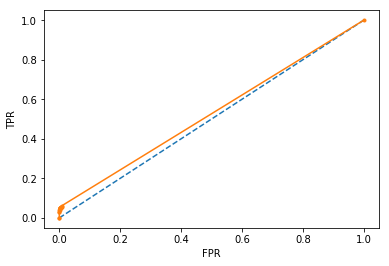

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/ColoridoTeste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

### Arquitetura 16 - Colorida 3

In [0]:
architecture = 'architecture_16_colorida3'

In [0]:
test_path = 'drive/My Drive/Base_CNN/Colorido3/Test'

#### Treino

In [0]:
c_images_train, c_areas_train = load_data('drive/My Drive/Base_CNN/Colorido3/Train/C',
                                          data_df, filetype='tif', size=(120, 120))
nc_images_train, nc_areas_train = load_data('drive/My Drive/Base_CNN/Colorido3/Train/NC',
                                            data_df, filetype='tif', size=(120, 120))

c_images_validation, c_areas_validation = load_data('drive/My Drive/Base_CNN/Colorido3/Validation/C',
                                                    data_df, filetype='tif', size=(120, 120))
nc_images_validation, nc_areas_validation = load_data('drive/My Drive/Base_CNN/Colorido3/Validation/NC',
                                                      data_df, filetype='tif', size=(120, 120))

In [0]:
images_train, areas_train, labels_train = prepare_data(
    c_images_train, nc_images_train, c_areas_train, nc_areas_train,
    normalization_method=3, return_y=True
)

images_validation, areas_validation, labels_validation = prepare_data(
    c_images_validation, nc_images_validation, c_areas_validation, nc_areas_validation,
    normalization_method=3, return_y=True
)

In [0]:
model = train_model(
    model_builder=model_14, weights_path_format='drive/My Drive/Resultado/Colorido/'
                                                 + architecture + '.hdf5',
    x=[images_train, areas_train], y=labels_train, batch_size=32, epochs=50,
    validation_data=([images_validation, areas_validation], labels_validation)
)

#### Teste - Test Precision: 19.65%, AUC: 0.501, Accuracy: 19.70%

In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.65%, AUC: 0.501, Accuracy: 19.70%


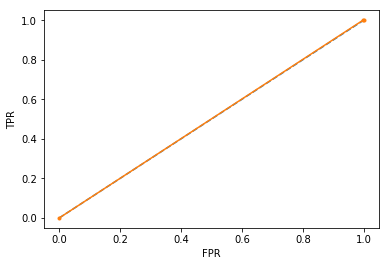

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## Arquiteturas Segmentadas

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Segmentado/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            area = float(linha[7])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict([regiao, np.array([area])], batch_size=32, verbose=0)
            # Probabilidade de ser da classe 1
            predicao = predicao[0][0]
            prob.append(predicao)
            
            # Se é um cromossomo:
            if (1 - predicao) < predicao:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob

### Arquitetura 16 - Binarizado 2

In [0]:
architecture = 'architecture_16_segmentado2'

In [0]:
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'

#### Treino

In [0]:
c_images_train, c_areas_train = load_data('drive/My Drive/Base_CNN/Binarizado2/Train/C',
                                          data_df, filetype='tif', size=(120, 120))
nc_images_train, nc_areas_train = load_data('drive/My Drive/Base_CNN/Binarizado2/Train/NC',
                                            data_df, filetype='tif', size=(120, 120))

c_images_validation, c_areas_validation = load_data('drive/My Drive/Base_CNN/Binarizado2/Validation/C',
                                                    data_df, filetype='tif', size=(120, 120))
nc_images_validation, nc_areas_validation = load_data('drive/My Drive/Base_CNN/Binarizado2/Validation/NC',
                                                      data_df, filetype='tif', size=(120, 120))

In [0]:
images_train, areas_train, labels_train = prepare_data(
    c_images_train, nc_images_train, c_areas_train, nc_areas_train,
    normalization_method=3, return_y=True
)

images_validation, areas_validation, labels_validation = prepare_data(
    c_images_validation, nc_images_validation, c_areas_validation, nc_areas_validation,
    normalization_method=3, return_y=True
)

In [0]:
model = train_model(
    model_builder=model_14, weights_path_format='drive/My Drive/Resultado/Segmentado/'
                                                 + architecture + '.hdf5',
    x=[images_train, areas_train], y=labels_train, batch_size=32, epochs=50,
    validation_data=([images_validation, areas_validation], labels_validation)
)

#### Teste - Test Precision: 94.12%, AUC: 0.851, Accuracy: 81.72%

In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 94.12%, AUC: 0.851, Accuracy: 81.72%


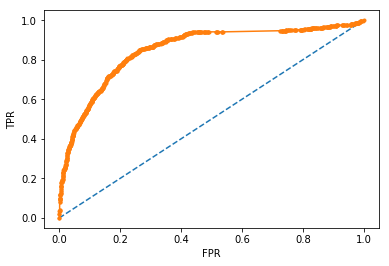

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

### Arquitetura 16 - Binarizado 3

In [0]:
architecture = 'architecture_16_segmentado3'

In [0]:
test_path = 'drive/My Drive/Base_CNN/Binarizado3/Test'

#### Treino

In [0]:
c_images_train, c_areas_train = load_data('drive/My Drive/Base_CNN/Binarizado3/Train/C',
                                          data_df, filetype='tif', size=(120, 120))
nc_images_train, nc_areas_train = load_data('drive/My Drive/Base_CNN/Binarizado3/Train/NC',
                                            data_df, filetype='tif', size=(120, 120))

c_images_validation, c_areas_validation = load_data('drive/My Drive/Base_CNN/Binarizado3/Validation/C',
                                                    data_df, filetype='tif', size=(120, 120))
nc_images_validation, nc_areas_validation = load_data('drive/My Drive/Base_CNN/Binarizado3/Validation/NC',
                                                      data_df, filetype='tif', size=(120, 120))

In [0]:
images_train, areas_train, labels_train = prepare_data(
    c_images_train, nc_images_train, c_areas_train, nc_areas_train,
    normalization_method=3, return_y=True
)

images_validation, areas_validation, labels_validation = prepare_data(
    c_images_validation, nc_images_validation, c_areas_validation, nc_areas_validation,
    normalization_method=3, return_y=True
)

In [0]:
model = train_model(
    model_builder=model_14, weights_path_format='drive/My Drive/Resultado/Segmentado/'
                                                 + architecture + '.hdf5',
    x=[images_train, areas_train], y=labels_train, batch_size=32, epochs=50,
    validation_data=([images_validation, areas_validation], labels_validation)
)

#### Teste - Test Precision: 19.69%, AUC: 0.808, Accuracy: 19.98%

In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.69%, AUC: 0.808, Accuracy: 19.98%


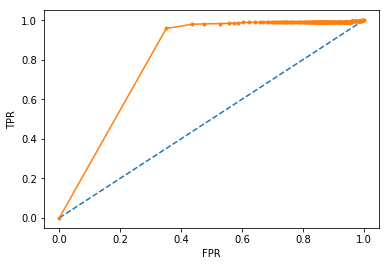

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')